# Cubed: an introduction

Tom White, August 2022

# Idea

Use Zarr as the underlying intermediate persistent storage between array operations.

![Cubed idea](cubed-idea.svg)

Tasks operate on Zarr chunks.

Tasks are embarassingly parallel, and their runtime memory can be tightly controlled.

# Primitives

* __Blockwise__: applies a function to multiple blocks from multiple inputs
* __Rechunk__: changes chunking, without changing shape/dtype

Dask introduced both of these operations.

__Almost all__ array operations can be implemented using these two primitives!

# Design

Cubed is composed of five layers: from the storage layer at the bottom, to the Array API layer at the top: 

![Five layer diagram](../design.svg)

# Demo

Cubed implements the [Python Array API standard](https://data-apis.org/array-api/latest/)

In [1]:
import cubed.array_api as xp
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2))

Notice that we specify chunks, just like in Dask Array.

In [2]:
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2))
c = xp.add(a, b)

Cubed uses lazy evaluation, so nothing has been computed yet.

In [3]:
c.compute()

array([[ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

# Computation plan

Cubed creates a computation _plan_, which is a directed acyclic graph (DAG).

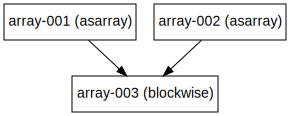

In [4]:
c.visualize()

Cubed will optimize the graph before computing it - by fusing blockwise (map) operations, for example.

Unlike a Dask graph which is at the task level, a Cubed graph is at the Zarr array level.

# Memory

Cubed models the memory used by every operation.

If required memory is less than what user specifies then an exception is raised __during planning__

In [5]:
import cubed
spec = cubed.Spec(work_dir="tmp", max_mem=100)  # not enough memory!
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2), spec=spec)
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2), spec=spec)
try:
    c = xp.add(a, b)
except ValueError as e:
    print(e)

Blockwise memory (192) exceeds max_mem (100)


# Peak memory

Cubed measures the peak amount of memory actually used during runtime.

Used to checked utilization, and improve the modelling.

```
  array_name    op_name  num_tasks  peak_mem_delta_mb_max  required_mem_mb  utilization
0  array-003    rechunk          1             103.727104         0.000064          NaN
1  array-004  blockwise          4             654.286848       800.000008     0.817859
2  array-007    rechunk          1             103.645184         0.000064          NaN
3  array-008  blockwise          4             654.364672       800.000008     0.817956
4  array-009  blockwise          4             796.954624      1200.000000     0.664129
```


# Runtimes

* __Modal__: new serverless platform, in private beta
    * Very easy to set up
    * Limited scalability (during beta)
* __Lithops__: multi-cloud serverless computing framework
    * Set up more involved (create a docker image)
    * Only tested on AWS Lambda with Cubed
* __Apache Beam (Google Cloud Dataflow)__: fully managed pipeline processing service
    * Some initial testing
    * Slow to spin up
* __Other Rechunker runtimes__
    * Dask, Prefect etc - not tried

# Example timeline

Adding two 20GB arrays on Modal

![Modal timeline](cubed-modal-timeline.png)

# Scalability and robustness

* Serverless scales out
    * AWS Lambda supports 1000 concurrent instances by default
    * PyWren paper: https://shivaram.org/publications/pywren-socc17.pdf
* Retries
    * Each task is tried three times before failing
* Stragglers
    * A backup task will be launched if a task is taking significantly longer than average

# Next steps

* Xarray integration
    * Improve Xarray integration with the Python Array API
        * Started in https://github.com/pydata/xarray/issues/3232
    * Add `gufunc` to Cubed: https://github.com/tomwhite/cubed/issues/67
* Improve Array API coverage
    * https://github.com/tomwhite/cubed/blob/main/api_status.md
* Use cases
    * Pangeo
    * sgkit
* Ease of use
    * Build Lithops image on cloud: https://github.com/lithops-cloud/lithops/issues/972
    * Realtime UI